In [1]:
import numpy as np
import mne
from scipy.io import loadmat
from braindecode import EEGClassifier
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, EEGNetv4, Deep4Net, HybridNet
from braindecode.models.util import models_dict
from skorch.dataset import ValidSplit
from skorch.callbacks import LRScheduler
import torch
import os
from bs4 import BeautifulSoup
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from mne.decoding import CSP

In [2]:
path1 = "./data/MT_2301_BP_Ymke.mat"

data = loadmat(path1)['data']

In [3]:
print(f"Amount of samples: {len(data)} \nAmount of channels: {len(data[0])}")

Amount of samples: 1440699 
Amount of channels: 20


In [4]:
def mat_to_raw(path, sfreq=500):
    data = loadmat(path)['data'] # this requires the loadmat function from scipy.io
    ch_names = [f"ch{i}" for i in range(len(data[0]) - 1)]
    ch_types = ['eeg' for _ in range(len(data[0]) - 1)]
    with open('data/MT_2301_BP_Ymke.xml', "r") as contents:
        content = contents.read()
        try:
            soup = BeautifulSoup(content, 'xml')
        except:
            soup = BeautifulSoup(content, 'lxml')

        titles = soup.find_all('name')
        labels = [x.text for x in titles][:-1]
        print(labels)
    # de O channels doen bij mij niks voor de accuracy
    remove_channels = ['P3 (7)', 'P4 (8)', 'Pz (19)', 'O1 (9)', 'O2 (10)', 'Fp1 (1)', 'Fp2 (2)', 'T7 (13)', 'T8 (14)', 'F7 (11)', 'F8 (12)', 'T7 (13)', 'T8 (14)', 'P7 (15)', 'P8 (16)']
    

    idx_remove = [labels.index(x) for x in remove_channels]
    ch_names = [x for x in labels if x not in remove_channels + ['marker']]
    ch_types = ['eeg' for _ in range(len(ch_names))]

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    data_r = data[:, :-1]
    data_r = np.delete(data_r, idx_remove, axis=1)

    markers = data[:, -1]
    raw = mne.io.RawArray(data_r.T, info)
    return raw, markers

raw, markers = mat_to_raw(path1)

['Fp1 (1)', 'Fp2 (2)', 'F3 (3)', 'F4 (4)', 'C3 (5)', 'C4 (6)', 'P3 (7)', 'P4 (8)', 'O1 (9)', 'O2 (10)', 'F7 (11)', 'F8 (12)', 'T7 (13)', 'T8 (14)', 'P7 (15)', 'P8 (16)', 'Fz (17)', 'Cz (18)', 'Pz (19)', 'marker']
Creating RawArray with float64 data, n_channels=6, n_times=1440699
    Range : 0 ... 1440698 =      0.000 ...  2881.396 secs
Ready.


Filtering raw data in 1 contiguous segment


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished


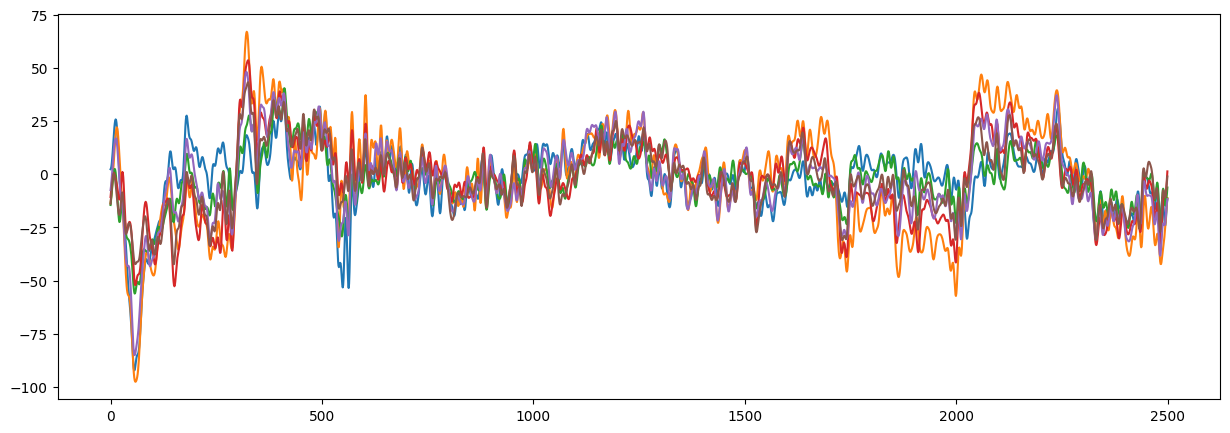

In [5]:
# apply band-pass filter
raw.filter(1, 40)

# Get a 5 second subset of the data
start = int(raw.info['sfreq'] * 5)  # Start 5 seconds in
stop = start + int(raw.info['sfreq'] * 5)  # End 5 seconds later
subset = raw.get_data(start=start, stop=stop)

# Plot the subset
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(subset.T)
plt.show()


In [6]:
# get value counts of markers
print(markers)
print(np.unique(markers, return_counts=True))

[0. 0. 0. ... 0. 0. 0.]
(array([0., 1., 2., 3., 4.]), array([1437359,     830,     835,     841,     834]))


In [7]:
def find_marker_starts(data):
  """
  Find the indices where markers start in a numpy array.

  Args:
    data: A numpy array of integers.

  Returns:
    A numpy array of shape (n_events, 2) where the first column is the index
    at which the marker starts, and the second column the marker it is about.
  """
  # Find the indices where the data changes from non-marker to marker.
  marker_starts = np.flatnonzero(np.diff(data) > 0) + 1

  # Get the markers at the start indices.
  markers = data[marker_starts]

  # Combine the start indices and markers into a single array.
  return np.vstack((marker_starts, markers)).T

# Example usage
data = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0])
result = find_marker_starts(data)
print(result)

[[ 4  1]
 [19  2]
 [27  5]]


In [8]:
# cast markers to int
markers = markers.astype(int)

marker_starts = find_marker_starts(markers)

In [9]:
marker_starts

array([[  19979,       1],
       [  24021,       2],
       [  28060,       4],
       [  32102,       3],
       [  36144,       1],
       [  40180,       2],
       [  44221,       3],
       [  48259,       4],
       [  52298,       4],
       [  56333,       2],
       [  60374,       1],
       [  64412,       3],
       [  68450,       3],
       [  72489,       2],
       [  76527,       4],
       [  80566,       1],
       [  84604,       1],
       [  88643,       4],
       [  92686,       2],
       [  96727,       3],
       [ 100766,       1],
       [ 104805,       4],
       [ 108842,       3],
       [ 112880,       2],
       [ 116919,       4],
       [ 120956,       3],
       [ 124996,       1],
       [ 129034,       2],
       [ 133072,       3],
       [ 137116,       4],
       [ 141157,       2],
       [ 145196,       1],
       [ 152667,       1],
       [ 156703,       2],
       [ 160741,       4],
       [ 164779,       3],
       [ 168819,       1],
 

In [10]:
# add column of 0s to middle of array
events = np.insert(marker_starts, 1, 0, axis=1)

In [11]:
events

array([[  19979,       0,       1],
       [  24021,       0,       2],
       [  28060,       0,       4],
       [  32102,       0,       3],
       [  36144,       0,       1],
       [  40180,       0,       2],
       [  44221,       0,       3],
       [  48259,       0,       4],
       [  52298,       0,       4],
       [  56333,       0,       2],
       [  60374,       0,       1],
       [  64412,       0,       3],
       [  68450,       0,       3],
       [  72489,       0,       2],
       [  76527,       0,       4],
       [  80566,       0,       1],
       [  84604,       0,       1],
       [  88643,       0,       4],
       [  92686,       0,       2],
       [  96727,       0,       3],
       [ 100766,       0,       1],
       [ 104805,       0,       4],
       [ 108842,       0,       3],
       [ 112880,       0,       2],
       [ 116919,       0,       4],
       [ 120956,       0,       3],
       [ 124996,       0,       1],
       [ 129034,       0,   

In [12]:
epochs = mne.Epochs(raw, events=events, event_id=None, tmin=0, tmax=5, baseline=None, preload=True)

Not setting metadata
321 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 321 events and 2501 original time points ...
0 bad epochs dropped


In [13]:
display(epochs)

X = epochs.get_data()
y = epochs.events[:, 2] - 1

X = X[y != 2]
y = y[y != 2]

y[y == 3] = 2



Number of events,321
Events,1: 802: 803: 814: 80
Time range,0.000 – 5.000 s
Baseline,off


/var/folders/n8/hmr8vlz93m53jxks_f0gz6qh0000gn/T/ipykernel_60677/320007835.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


In [14]:
def stop_nb_execution():
    raise KeyboardInterrupt

# stop_nb_execution()

In [15]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(192, 6, 2501)

(48, 6, 2501)

(192,)

(48,)

In [16]:
csp_model = CSP(n_components=100, reg=None, log=True, norm_trace=False)
X_train_csp = csp_model.fit_transform(X_train, y_train)
X_test_csp = csp_model.transform(X_test)

# train a classifier
clf = SVC()
clf.fit(X_train_csp, y_train)
score = clf.score(X_test_csp, y_test)
print(f"SVM accuracy: {score:.4f}")

clf = KNeighborsClassifier()
clf.fit(X_train_csp, y_train)
score = clf.score(X_test_csp, y_test)
print(f"KNN accuracy: {score:.4f}")

clf = LinearDiscriminantAnalysis()
clf.fit(X_train_csp, y_train)
score = clf.score(X_test_csp, y_test)
print(f"LDA accuracy: {score:.4f}")

Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 6 dim * 8.5e+15  max singular value)
    Estimated rank (mag): 6
    MAG: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 6 dim * 9.1e+15  max singular value)
    Estimated rank (mag): 6
    MAG: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 6 dim * 9.6e+15  max singular value)
    Estimated rank (mag): 6
    MAG: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating covariance using EMPIRICAL
Done.
SVM accuracy: 0.5625
KNN accuracy: 0.5625
LDA accuracy: 0.6042


In [17]:


models_available = list(models_dict.keys())
print(*models_available, sep='\n')

ATCNet
Deep4Net
DeepSleepNet
EEGConformer
EEGITNet
EEGInception
EEGInceptionERP
EEGInceptionMI
EEGNetv1
EEGNetv4
EEGResNet
HybridNet
ShallowFBCSPNet
SleepStagerBlanco2020
SleepStagerChambon2018
SleepStagerEldele2021
TCN
TIDNet
USleep


In [18]:
cuda = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220  # random seed to make results reproducible
set_random_seeds(seed=seed, cuda=cuda)

print(f"Device: {device}\nSeed: {seed}")

Device: cpu
Seed: 20200220


In [19]:
n_classes = len(np.unique(y))
classes = list(range(n_classes))
n_chans = X.shape[1]
input_window_samples = X.shape[2]

print(f"Classes: {classes}\nNumber of classes: {n_classes}\nNumber of channels: {n_chans}\nInput window samples: {input_window_samples}")

model = ShallowFBCSPNet(
    in_chans=n_chans,
    n_classes=n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

print(model)

if cuda:
    model.cuda()
    print("Model on GPU")

Classes: [0, 1, 2]
Number of classes: 3
Number of channels: 6
Input window samples: 2501
Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 6, 2501]              [1, 3]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 6, 2501]              [1, 6, 2501, 1]           --                        --
├─Rearrange (dimshuffle): 1-2            [1, 6, 2501, 1]           [1, 1, 2501, 6]           --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 2501, 6]           [1, 40, 2477, 1]          10,640                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 2477, 1]          [1, 40, 2477, 1]          80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 2477, 1]          [1, 40, 2477, 1]          --                        --
├─AvgPool2d (pool): 1-6                  [1, 40

/Users/tarasplint/opt/anaconda3/envs/demo_env/lib/python3.10/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'in_chans' is depreciated. Use 'n_chans' instead.
  warnings.warn(
/Users/tarasplint/opt/anaconda3/envs/demo_env/lib/python3.10/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
/Users/tarasplint/opt/anaconda3/envs/demo_env/lib/python3.10/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/tarasplint/opt/anaconda3/envs/demo_env/lib/python3.10/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [20]:
lr = 0.0625 * 0.01
weight_decay = 0.8 * 0.001
batch_size = 64
n_epochs = 50

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    max_epochs=n_epochs,
)

clf.fit(X_train, y_train)

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5938        1.5482  0.0006  0.6864
      2            0.7240        1.0171  0.0006  0.6246
      3            0.8021        0.8466  0.0006  0.5992
      4            0.8542        0.5781  0.0006  0.6289
      5            0.9010        0.4519  0.0006  0.6566
      6            0.9219        0.4914  0.0006  0.6327
      7            0.9583        0.2553  0.0006  0.6493
      8            0.9740        0.2908  0.0006  0.5900
      9            0.9844        0.2691  0.0006  0.5602
     10            0.9896        0.2012  0.0006  0.5520
     11            0.9948        0.2155  0.0006  0.5958
     12            0.9948        0.1492  0.0006  0.6366
     13            0.9948        0.2018  0.0005  0.5984
     14            1.0000        0.1436  0.0005  0.6679
     15            1.0000        0.1201  0.0005  0.6577
     16            1.0000        0.1174  0.0005 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 6, 2501]              [1, 3]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 6, 2501]              [1, 6, 2501, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 6, 2501, 1]           [1, 1, 2501, 6]           --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 2501, 6]           [1, 40, 2477, 1]          10,640                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 2477, 1]          [1, 40, 2477, 1]          80                        --
  ├─Expression (conv_nonlin_exp): 

In [21]:
# Evaluate the model
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 68.75%


In [22]:
randx = np.random.rand(1, 19, 2501)
clf.predict(randx)

AssertionError: 

In [ ]:
y_pred

In [ ]:
X_test.shape